<a href="https://colab.research.google.com/github/OpenForest4D/ALS_Notebooks/blob/main/CHM_lidar_pc_lidR_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Generating Canopy Height Model (CHM) and forest canopy metrics from lidar point clouds using lidR**

This R notebook processes airborne lidar data (in LAZ/LAS format) using the lidR package (https://r-lidar.github.io/lidRbook/) to generate essential forestry and ecology products. The workflow produces Canopy Height Models (CHM), smoothed CHMs, gridded canopy metrics, individual tree detections with convex hulls, and crown-level measurements. All processing steps are sequentially organized to ensure reproducible analysis of point cloud data.

This work was supported by the National Science Foundation under awards 2409885, 2409886 & 2409887. - www.openforest4d.org

Authors: Kai Lin, Viswanath Nandigam

**Step 0: Install and Load Packages**

A compressed package containing all required libraries is available for download to save setup time. Alternatively, you may install the libraries individually, although this process can take up to 25 minutes. An option to save the package directly to your local disk is also provided below.

In [ ]:

# Option 1: Download compressed package containing all required libraries

system("wget https://zenodo.org/records/17611774/files/forestlib.tar.gz")
system("tar -xzf forestlib.tar.gz")

# Add forestlib to R library search path
.libPaths("forestlib")

# Ensure pacman is available
if (!requireNamespace("pacman", quietly = TRUE)) {
  install.packages("pacman")
}

# Load packages WITHOUT reinstalling
pacman::p_load(
  lidR,
  terra,
  raster,
  sp,
  sf,
  RCSF,
  install = FALSE,
  update = FALSE
)

# Option 2: Install libraries individually ()

# # Set CRAN mirror once globally
# options(repos = "https://cran.rstudio.com/")

# # Install pacman only if not available
# if (!requireNamespace("pacman", quietly = TRUE)) {
#   install.packages("pacman")
# }

# # Load packages using pacman for easier management in Colab
# pacman::p_load(
#   lidR,        # Lidar data processing
#   terra,       # Raster handling
#   raster,      # Legacy support (used in Compute Canopy Metrics Grid)
#   sp,          # Spatial data structures
#   sf,          # Simple features
#   RCSF         # Cloth Simulation Filter
#   #viridis     # Optional for Color palettes in plots
#   #future      # Optional for parallel processing
# )

# # Additional option: Cache installed packages in Google Drive (or local disk)
#
# # Step 1:
#
# # Create library directory
# dir.create("forestlib")
#
# # Set library path
# .libPaths("forestlib")
#
# # Install packages to local library using all cores
# install.packages(c("lidR", "terra", "raster", "sp", "sf", "RCSF"),
#                 lib = "forestlib",
#                 Ncpus = parallel::detectCores(),
#                 repos = "https://cloud.r-project.org")
#
# # Compress local library
# utils::tar("forestlib.tar.gz", files = "forestlib")
#
# # Upload to Google Drive (overwrite by default)
# library(googledrive)
# drive_upload("forestlib.tar.gz")
#
# # Step 2:
#
# # Mount Google Drive
# system("google-drive-ocamlfuse ~/drive")
#
# # Copy tarball from Google Drive
# file.copy("~/drive/MyDrive/forestlib.tar.gz", "forestlib.tar.gz")
#
# # Extract library tarball
# untar("forestlib.tar.gz", exdir = "forestlib")
#
# # Set library path
# .libPaths("forestlib")
#
# # Load packages to verify
# library(lidR)
# library(terra)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘wk’, ‘e1071’, ‘s2’, ‘units’, ‘abind’, ‘classInt’, ‘lazyeval’, ‘rgl’, ‘rlas’, ‘sf’, ‘stars’, ‘terra’, ‘BH’, ‘RcppArmadillo’



lidR installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘sp’



raster installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


RCSF installed



**Step 1: Define Custom Metrics Function**

Define the f_metrics function for canopy metrics computation (used later). The strata heights have been pre-defined to be between 2 and 5 meters.

In [2]:
f_metrics <- function(Z, n) {
  # Strata: Proportion of Z values in the range of 2 to 5 meters
  strata = if (length(Z) > 0) sum(Z > 2 & Z < 5, na.rm = TRUE) / sum(!is.na(Z)) else 0
  # Canopy Cover: Proportion of returns in the first return
  Zcov <- sum(Z >= 2 & n == 1) / sum(n == 1)
  # Compute percentiles of Z values.
  # From 5% to 95% increased by 5%; from 96% to 100% increased by 1%.
  percentiles = quantile(Z, c(seq(0.05, 0.95, 0.05), seq(0.96, 1, 0.01)))

  # Create a list of computed metrics
  list_metrics = list(
    COV = Zcov,            # Canopy cover
    Hmean = mean(Z),       # Mean canopy height
    HSD = sd(Z),           # Standard deviation of height
    HMAX = max(Z),         # Maximum height
    S = strata             # Strata value
  )

  # Add percentile metrics to the list
  for (i in seq_along(percentiles)) {
    list_metrics[[paste0("H", gsub("\\.", "", names(percentiles)[i]), "TH")]] <-
      percentiles[i]
  }

  return(list_metrics)  # Return the list of metrics
}

**Step 2: Specify Input lidar point cloud file and resolution**

Specify the input laz file and parameters (e.g., resolution). Here we use an example laz file from OpenTopography (www.opentopography.org, dataset DOI - https://doi.org/10.5069/G96M351N)

In [3]:
# Define the URL for the LAZ file
lidar_url <- "https://opentopography.s3.sdsc.edu/pc-bulk/CA18_Thompson/273500_4172000.laz"

# Create a temporary file with .laz extension to download the file
temp_laz <- tempfile(pattern = "lidar_", fileext = ".laz")

# Download the LAZ file to the temporary location
download.file(lidar_url, temp_laz, mode = "wb")

# Create output directory if it doesn't exist
output_dir <- "/content/lidar_output"
if (!dir.exists(output_dir)) {
  dir.create(output_dir, recursive = TRUE)
}

# Set raster resolution (e.g., 1 meter)
res <- 1

**Step 3: Read lidar point cloud data file**

Use the readLAS function from the lidR R package to read the lidar point cloud file - select only the  X, Y, Z, intensity, number of returns and classification and excludes points with a Z (elevation) value below 0. See [this blog](https://openforest4d.org/lidar-point-cloud-data/) post to learn more about the information included in a lidar point cloud.

In [4]:
# Load the LAZ file using lidR readLAS function
las <- readLAS(temp_laz, select = "xyzrnc", filter = "-drop_z_below 0")
if (is.empty(las)) {
  stop("Error: LAZ file could not be read or is empty.")
}

# Example: Print summary of the LAS file to confirm successful load
print(summary(las))

class        : LAS (v1.4 format 3)
memory       : 229.9 Mb 
extent       : 273499.8, 274000.4, 4172000, 4172500 (xmin, xmax, ymin, ymax)
coord. ref.  : NAD83(2011) / UTM zone 11N 
area         : 253584 m²
points       : 6.7 million points
type         : airborne
density      : 26.41 points/m²
density      : 25.18 pulses/m²
File signature:           LASFm� 
File source ID:           57453 
Global encoding:
 - GPS Time Type: GPS Week Time 
 - Synthetic Return Numbers: no 
 - Well Know Text: CRS is WKT 
 - Aggregate Model: false 
Project ID - GUID:        00000000-0000-0000-0000-000000000000 
Version:                  1.4
System identifier:        PDAL 
Generating software:      PDAL 2.2.0 (ff32c2) 
File creation d/y:        91/2019
header size:              375 
Offset to point data:     1777 
Num. var. length record:  2 
Point data format:        3 
Point data record length: 34 
Num. of point records:    6696583 
Num. of points by return: 6384399 267084 41236 3864 0 0 0 0 0 0 0 0 0 0 0

**Step 4: Remove Duplicates**

Identify and remove duplicated points within the lidar point cloud file.

In [5]:
las <- filter_duplicates(las)
print(las)  # Check after removal

class        : LAS (v1.4 format 3)
memory       : 229.8 Mb 
extent       : 273499.8, 274000.4, 4172000, 4172500 (xmin, xmax, ymin, ymax)
coord. ref.  : NAD83(2011) / UTM zone 11N 
area         : 253584 m²
points       : 6.69 million points
type         : airborne
density      : 26.4 points/m²
density      : 25.17 pulses/m²


**Step 5: Classify and Remove Noise**

Classify and filter out noise using Statistical Outlier Removal (SOR). The SOR algorithm checks each point's mean distance to its 10 nearest neighbors (k=10) and marks points as noise if their distance is greater than the average plus 3 times the standard deviation (m=3). The quantile = FALSE means it uses standard deviation thresholding rather than quantile-based.

In [6]:
las <- classify_noise(las, algorithm = sor(k = 10, m = 3, quantile = FALSE))
las <- filter_poi(las, Classification != 18)  # Remove noise (Class 18)
print(las)  # Inspect

class        : LAS (v1.4 format 3)
memory       : 225.1 Mb 
extent       : 273499.8, 274000.4, 4172000, 4172500 (xmin, xmax, ymin, ymax)
coord. ref.  : NAD83(2011) / UTM zone 11N 
area         : 253520 m²
points       : 6.56 million points
type         : airborne
density      : 25.86 points/m²
density      : 24.81 pulses/m²


**Step 6: Generate Digital Surface Model (DSM)**

Create and plot the DSM. The DSM measures the top elevation of the landscape, including vegetation & buildings.

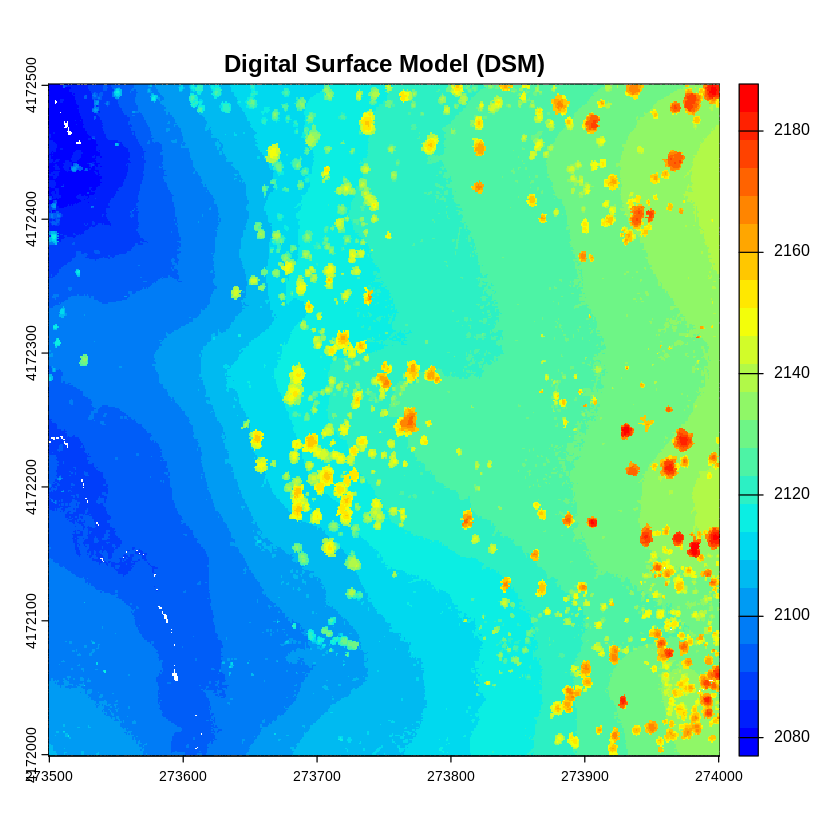

In [7]:
dsm <- rasterize_canopy(las, res = res, algorithm = p2r())
col <- height.colors(24)  # Color palette
#col <- colorRampPalette(c("#7B4F12", "#B27243", "#D6A45F", "#E6C96A", "#C8D974", "#82A84B", "#99C092"))(24) #optional custom color
#col <- colorRampPalette(c("#704214", "#a76f3a", "#c1a066", "#8aa06e", "#4c7a45", "#236623"))(24) #optional custom color 2 -This ramp uses earth-tone browns transitioning into greens with careful contrast to be perceivable to colorblind people including red-green deficiencies.
plot(dsm, col = col, main = "Digital Surface Model (DSM)")

**Step 7: Classify Ground Points**

Classify ground using Cloth Simulation Filter (CSF). The cloth resolution and class threhold parameters vcan be edited. See [this publication](https://www.mdpi.com/2072-4292/8/6/501) on the algorithm.

In [8]:
las <- classify_ground(las, csf(cloth_resolution = 2, rigidness = 3L))
print(las)  # Check classifications

Original dataset already contains 1177742 ground points. These points were reclassified as 'unclassified' before performing a new ground classification.



class        : LAS (v1.4 format 3)
memory       : 225.1 Mb 
extent       : 273499.8, 274000.4, 4172000, 4172500 (xmin, xmax, ymin, ymax)
coord. ref.  : NAD83(2011) / UTM zone 11N 
area         : 253520 m²
points       : 6.56 million points
type         : airborne
density      : 25.86 points/m²
density      : 24.81 pulses/m²


**Step 8: Generate Digital Terrain Model (DTM)**

Generate DTM (bare earth surface) using Triangulated Irregular Network (TIN) algorithm which constructs a mesh of triangles between ground points and interpolates elevations to generate a continuous surface.

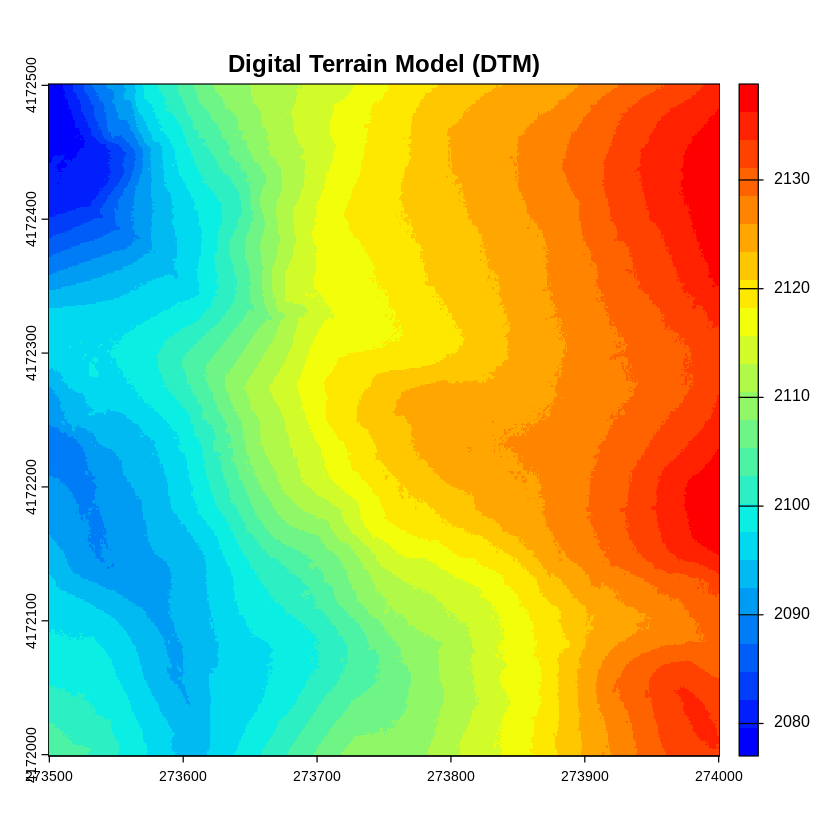

In [9]:
dtm <- rasterize_terrain(las, res = res, algorithm = tin())
plot(dtm, col = col, main = "Digital Terrain Model (DTM)")
#plot_dtm3d(dtm)  # Optional 3D plot (requires snapshot in Colab)

**Step 9: Normalize Point Cloud**

Perform height normalization of the lidar point cloud data relative to the DTM (height above ground).

In [10]:
las_norm <- normalize_height(las, algorithm = dtm)

**Step 10: Generate Canopy Height Model (CHM)**

Create and plot the CHM (vegetation heights).  Learn about canopy height models [here](https://openforest4d.org/what-is-a-canopy-height-model/).

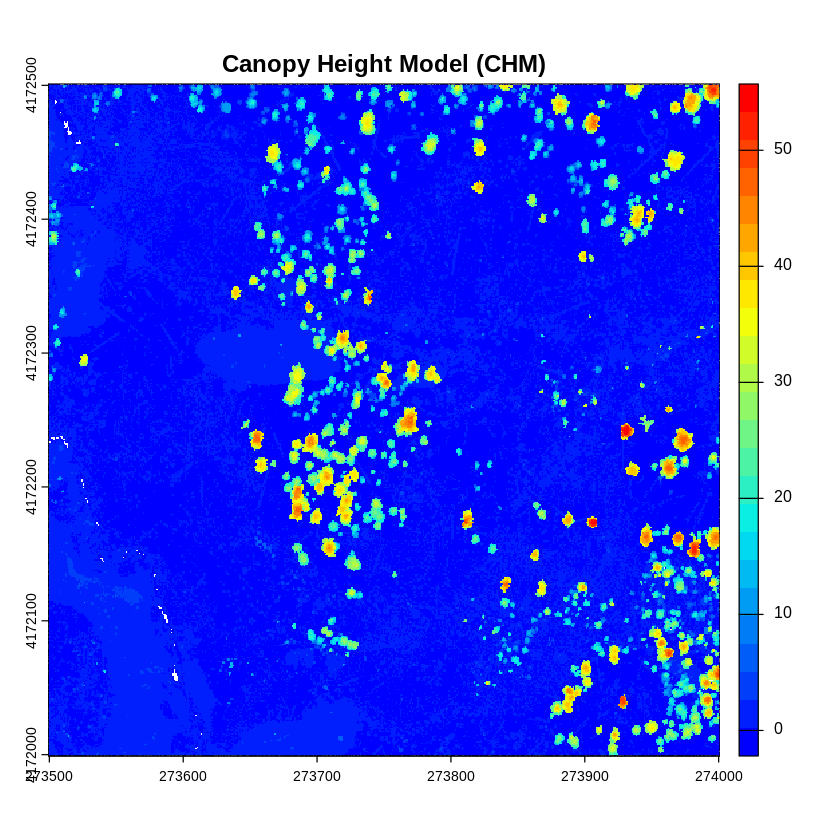

In [11]:
chm <- rasterize_canopy(las_norm, res = res, algorithm = p2r())
plot(chm, col = col, main = "Canopy Height Model (CHM)")

# Save CHM and normalized LAS (optional)
#writeRaster(chm, file.path(output_dir, "CHM.tif"), overwrite = TRUE)
#writeLAS(las_norm, file.path(output_dir, "laz_norm.laz"))

**Step 11: Compute Canopy Metrics Grid**

Apply custom metrics to generate a gridded raster of canopy statistics.

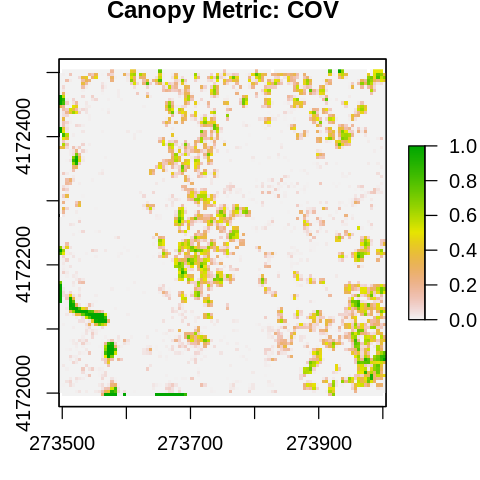

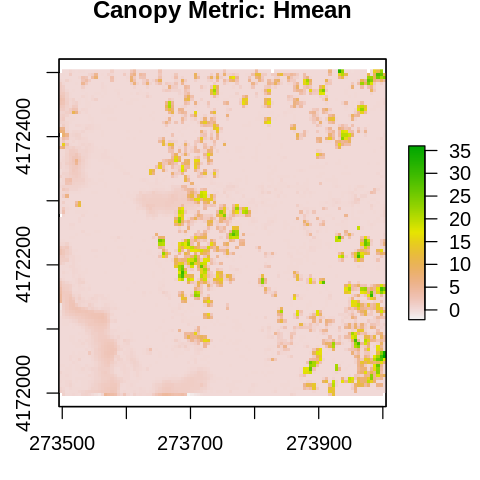

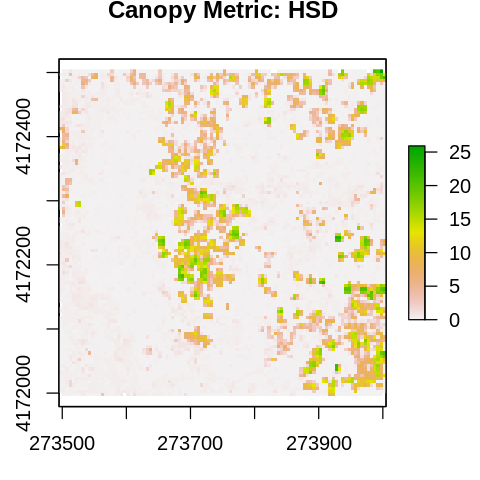

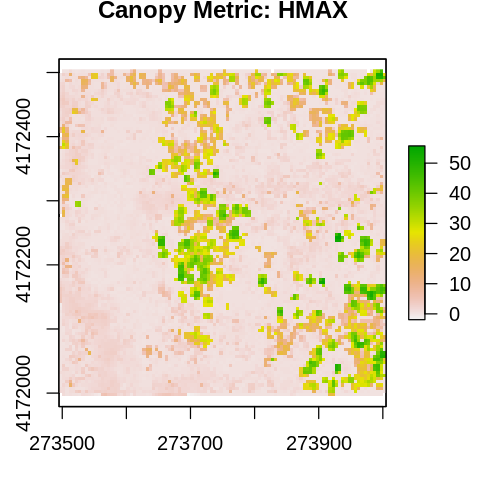

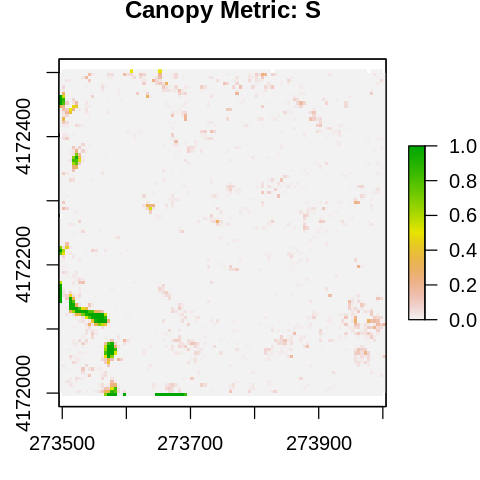

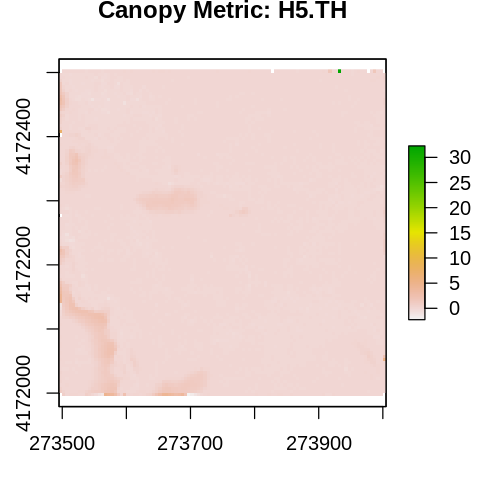

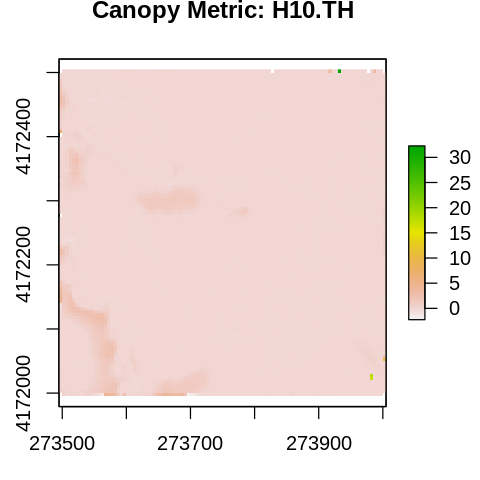

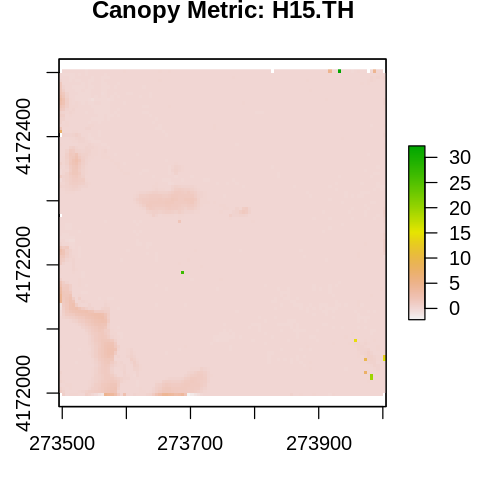

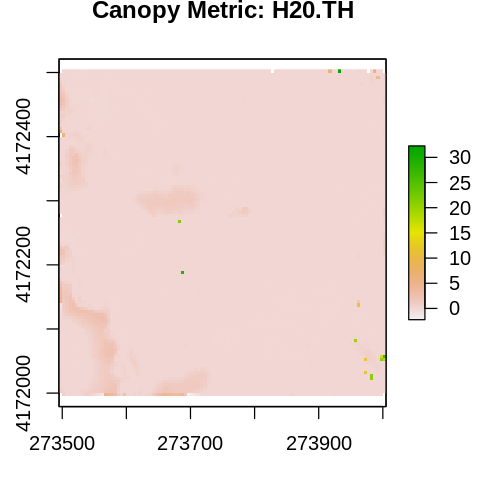

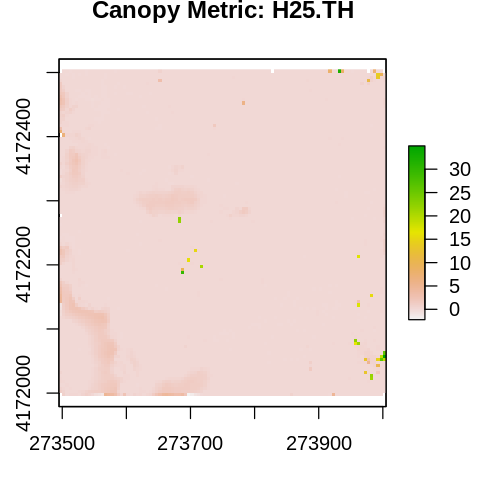

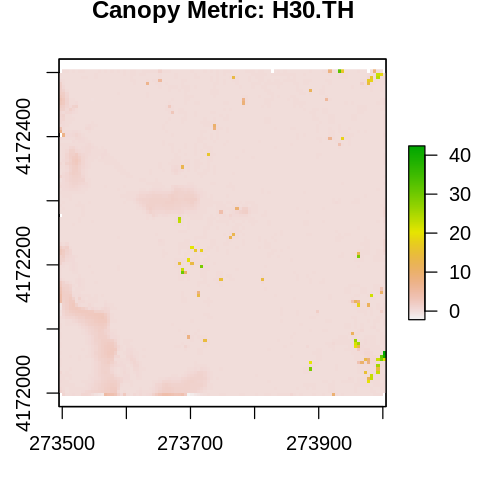

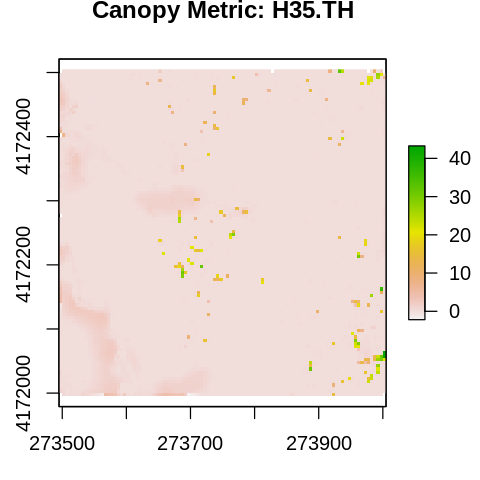

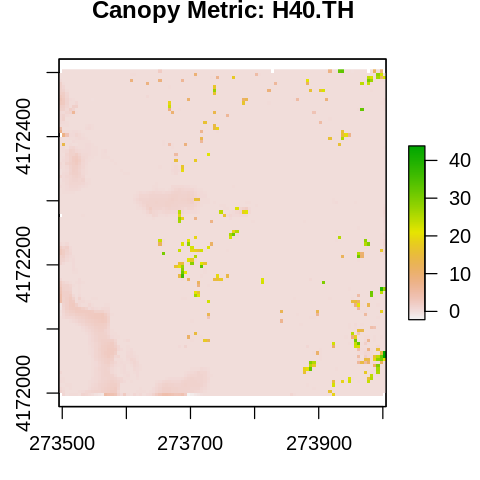

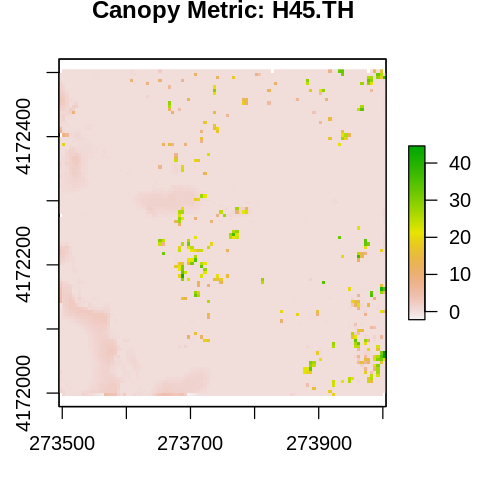

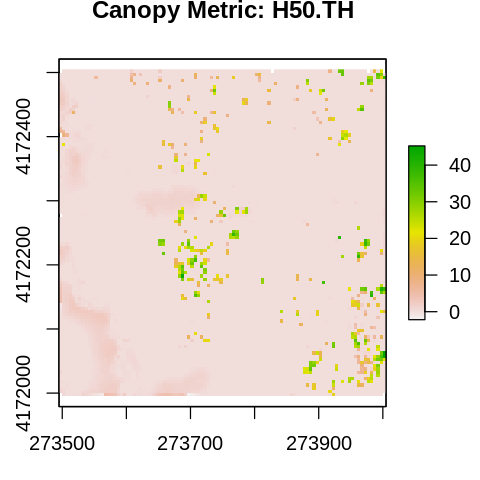

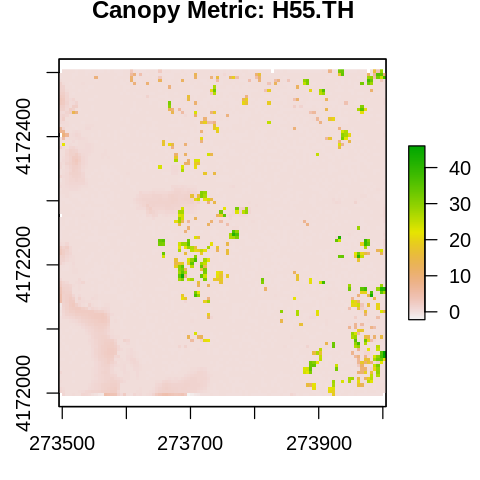

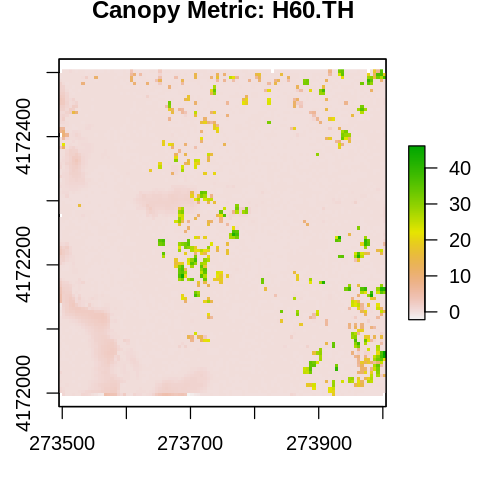

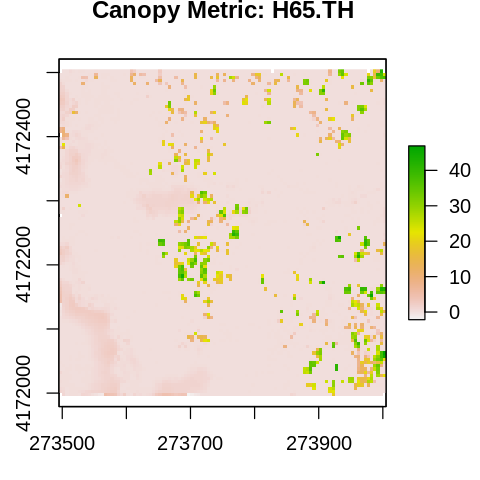

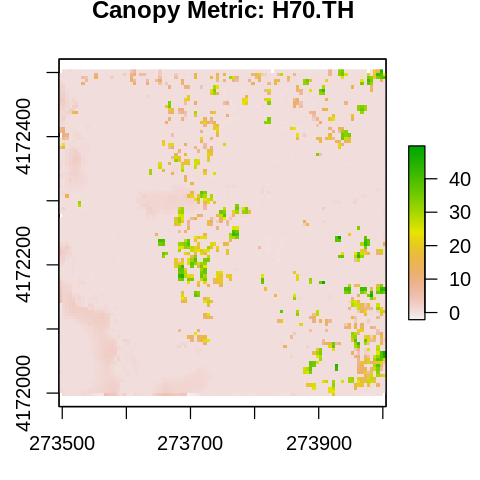

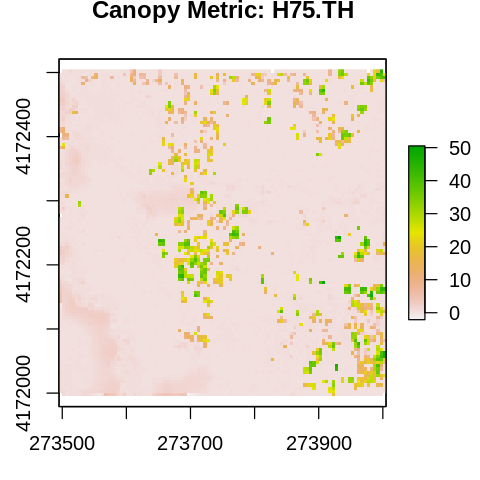

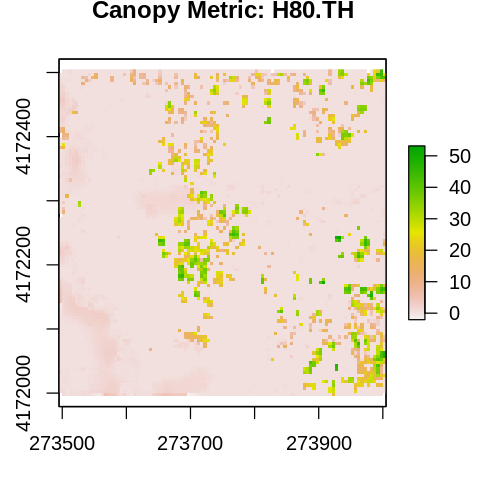

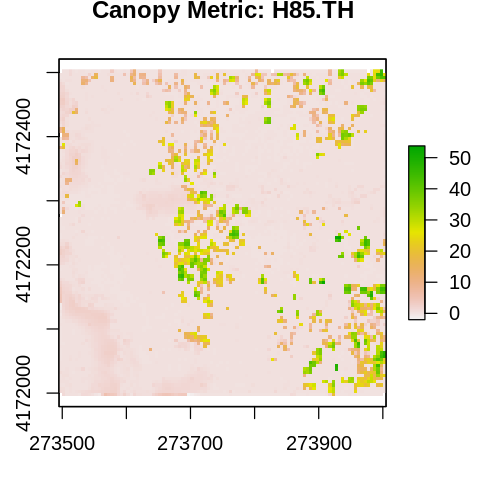

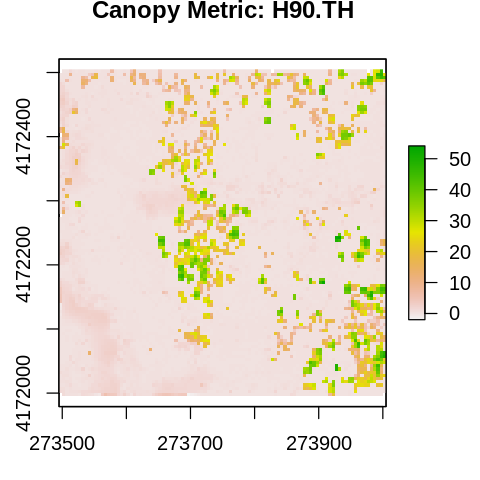

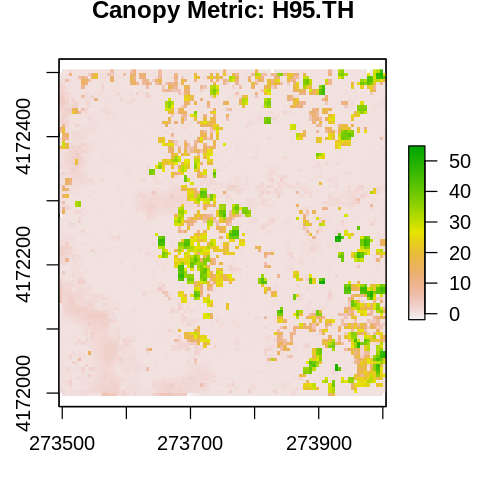

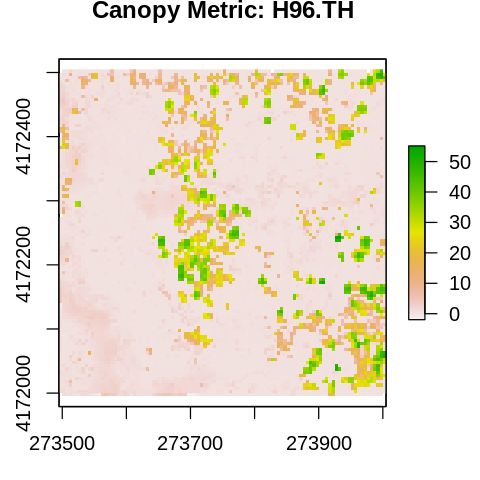

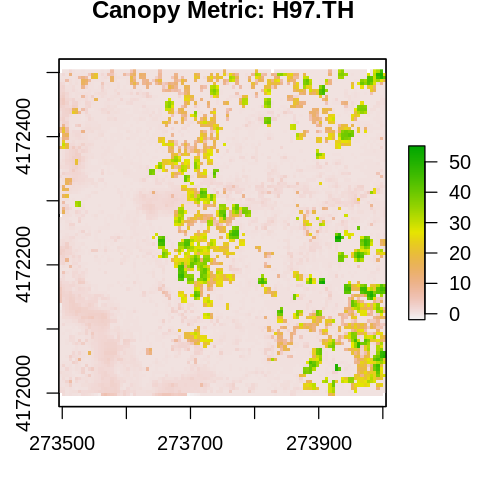

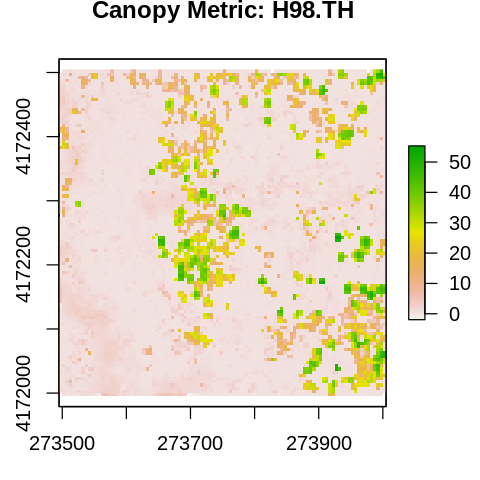

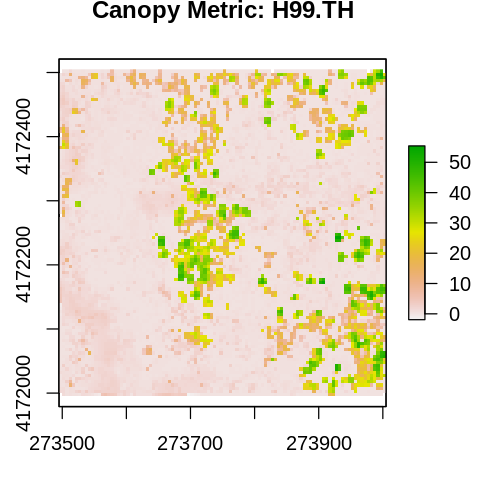

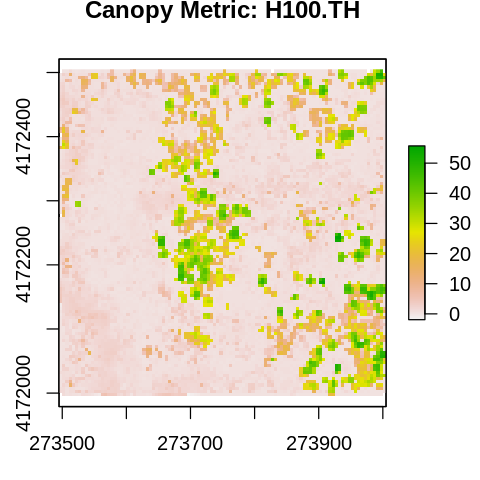

In [12]:
canopy_metrics_grid <- grid_metrics(las_norm,
                                    func = ~f_metrics(Z, ReturnNumber),
                                    res = 5)

# Make each metric plot large
options(repr.plot.width = 4, repr.plot.height = 4)

# Loop through layers
for (name in names(canopy_metrics_grid)) {
  terra::plot(
    canopy_metrics_grid[[name]],
    main = paste("Canopy Metric:", name),
    legend.width = 1.5
  )
}


**Step 12: Smooth CHM**

Apply median smoothing to the CHM for better tree detection.

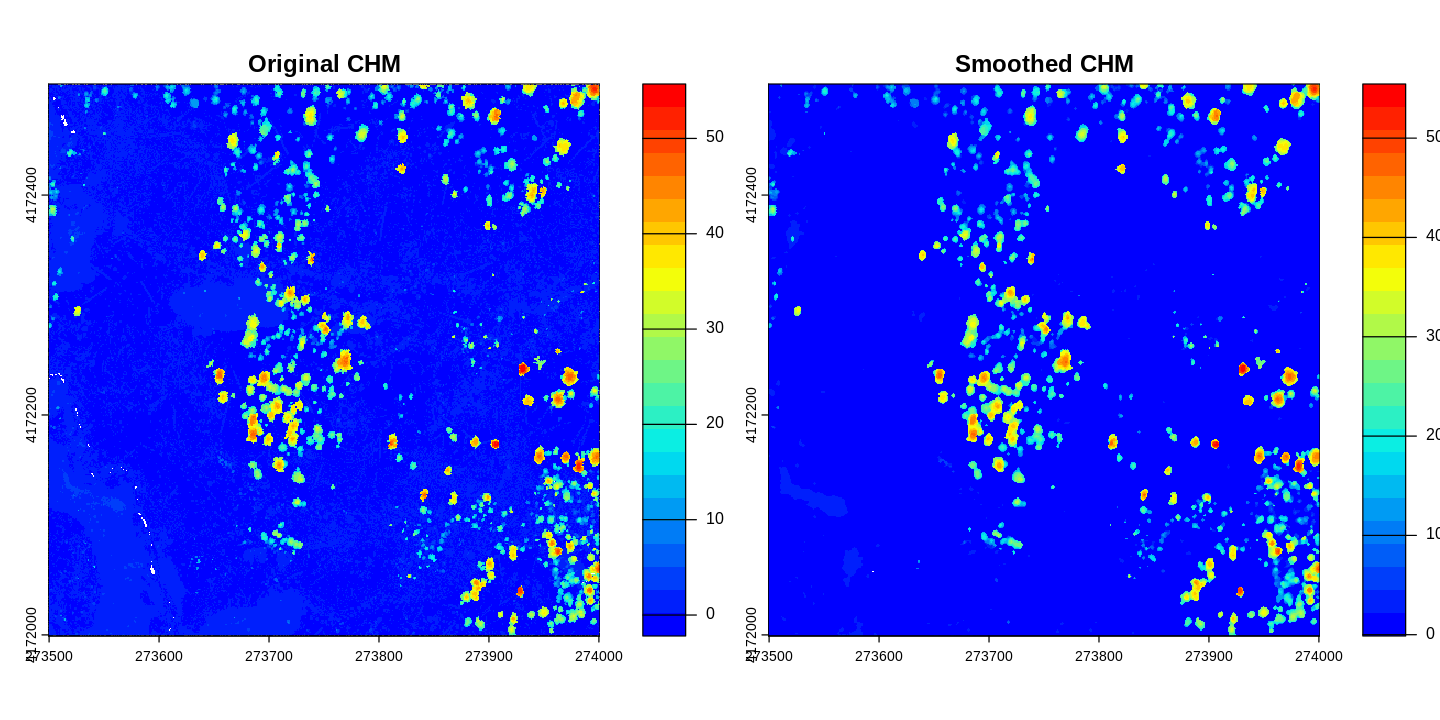

In [13]:
kernel <- matrix(1, 3, 3)  # 3x3 kernel
chm_smoothed <- terra::focal(chm, w = kernel, fun = median, na.rm = TRUE)

# Increase plot size (in inches)
options(repr.plot.width = 12, repr.plot.height = 6)

# Visualize original vs. smoothed
par(mfrow = c(1, 2))
plot(chm, col = col, main = "Original CHM")
plot(chm_smoothed, col = col, main = "Smoothed CHM")

# Optional - Save smoothed CHM
# writeRaster(chm_smoothed, file.path(output_dir, "CHM_smoothed.tif"), overwrite = TRUE)

**Step 13: Detect Tree Tops**

Locate tree tops using local maxima filter on smoothed CHM. The a local maximum filter (lfm) can be edited, and this filter works by identifying local maxima within a window of a specified dimension. See [this blog post](https://openforest4d.org/tree-identification-and-segmentation/) for examples of how this parameter impacts how trees are identified.

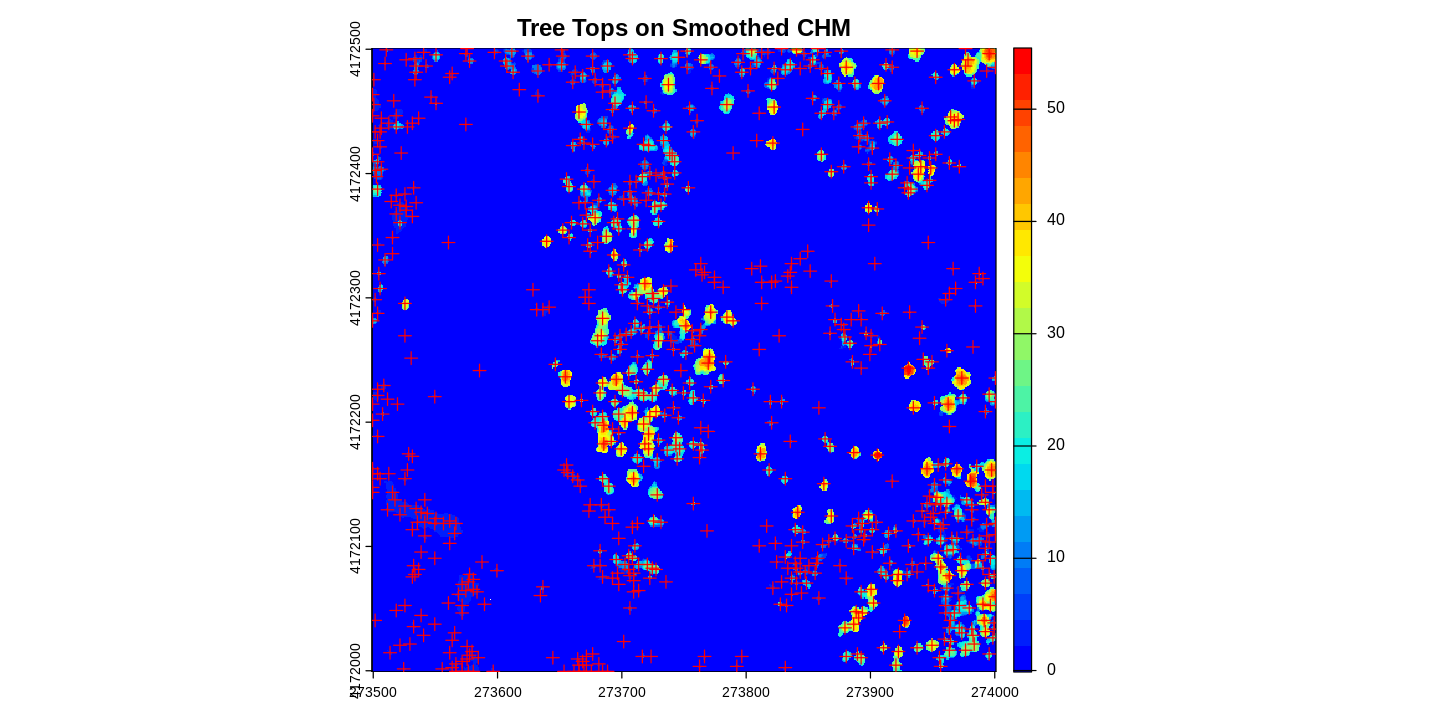

In [14]:
ttops <- locate_trees(chm_smoothed, lmf(5))  # 5m radius
plot(chm_smoothed, col = col, main = "Tree Tops on Smoothed CHM")
plot(sf::st_geometry(ttops), add = TRUE, pch = 3, col = "red")

**Step 14: Segment Individual Trees**

Segment trees using Silva2016 algorithm (https://rdrr.io/cran/lidR/man/its_silva2016.html).

In [15]:
las_itc <- segment_trees(las_norm, silva2016(chm_smoothed, ttops))
plot(las_itc, color = "treeID", main = "Segmented Trees")

**Step 15: Delineate Tree Crowns**

Compute convex hulls for tree crowns and plot. A convex hull is the smallest convex polygon that contains all the points with the tree. This plots the CHM  with tree gorwns outlined in black.

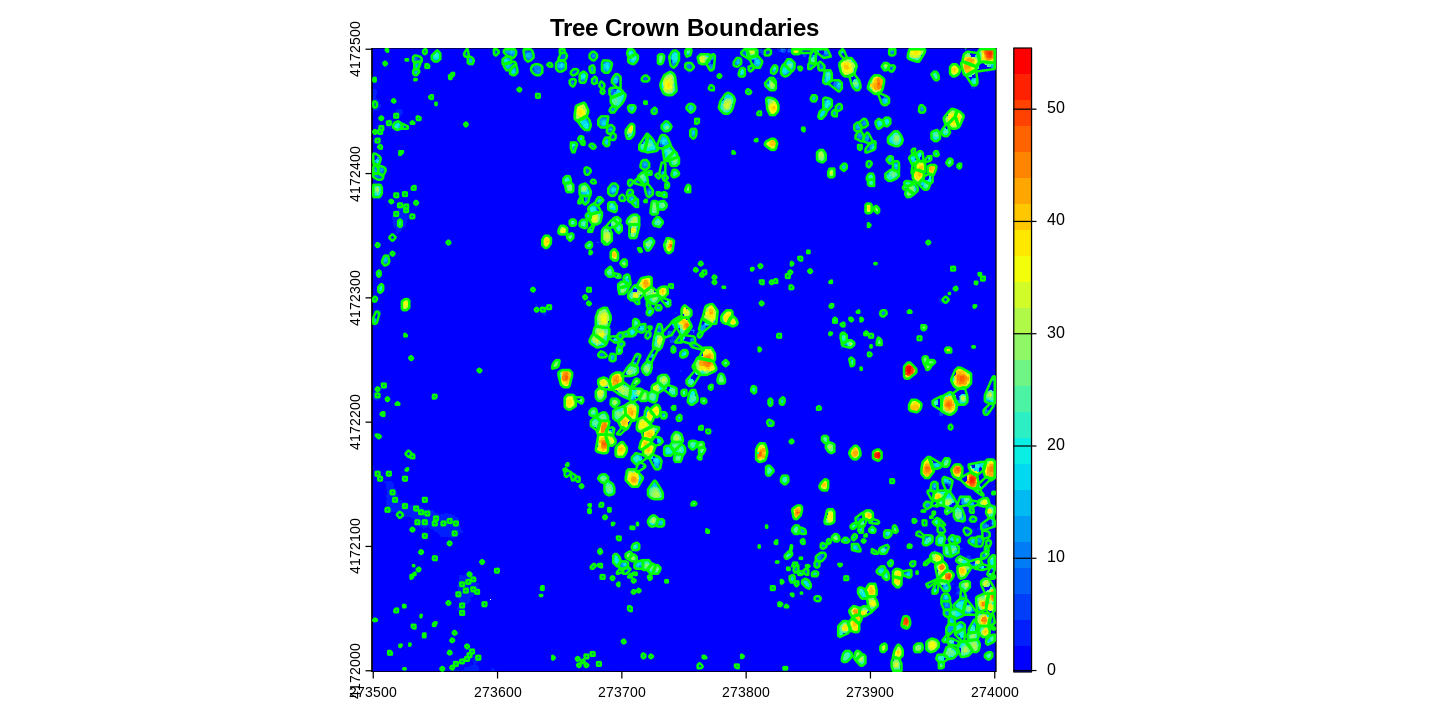

In [16]:
convex_hulls <- delineate_crowns(las_itc)
plot(chm_smoothed, col = col, main = "Tree Crown Boundaries")
plot(convex_hulls, add = TRUE, lwd = 2, border = "green")

**Step 16: Compute Crown-Level Metrics (Optional)**

Define and apply a function to compute metrics per crown (e.g., max height, mean height).

Simple feature collection with 795 features and 6 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 273500 ymin: 4172000 xmax: 274000 ymax: 4172500
Projected CRS: NAD83(2011) / UTM zone 11N
First 10 features:
   treeID  maxz     meanz       sdz       varz     p98
1       5 13.65  6.520206  5.601925  31.381565 13.2904
2       6  9.46  2.493024  2.835884   8.042238  8.7948
3       7 34.16 13.020497 11.575033 133.981397 32.7786
4       8 37.46 14.354069 15.474443 239.458392 36.7500
5       9 13.49  3.878207  4.475311  20.028410 12.6530
6      10 17.31  5.632691  5.330437  28.413554 14.3446
7      11 24.92  8.008389  9.194815  84.544631 23.3772
8      12 30.46  6.277875  8.066295  65.065123 29.6108
9      13 38.09 14.510768 15.585703 242.914130 37.1352
10     14  4.55  1.230615  1.548801   2.398783  4.1872
                         geometry
1  POLYGON ((273511.9 4172498,...
2  POLYGON ((273654 4172497, 2...
3  POLYGON ((273808 4172495, 2...
4  POLYGON ((273843.7 4172498,.

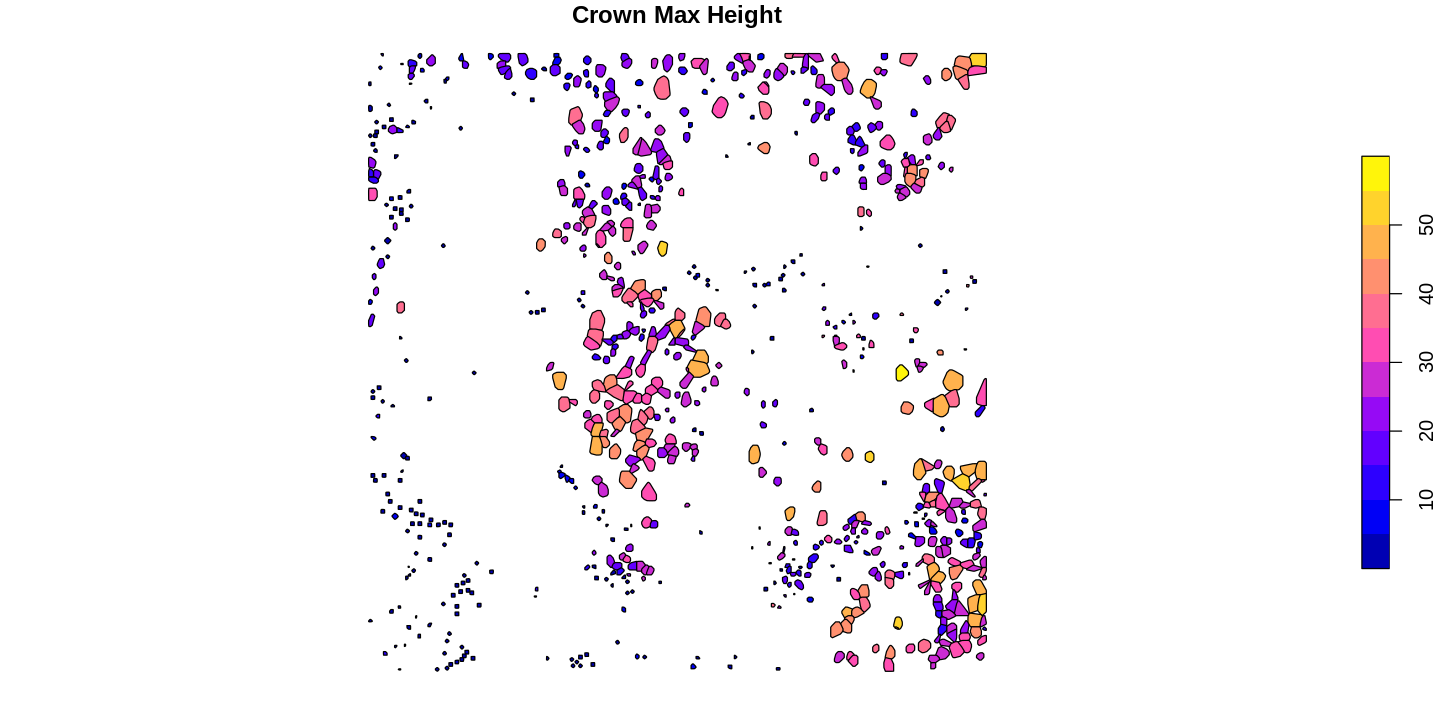

In [17]:
# Define crown metrics function
fun <- ~list(maxz = max(Z),               # Maximum height
             meanz = mean(Z),             # Mean height
             sdz = sd(Z),                 # Standard deviation of height
             varz = var(Z),               # Variance of height
             p98 = quantile(Z, 0.98))     # 98th percentile

# Compute crown metrics
crown_metrics <- crown_metrics(las_itc, func = fun, geom = "convex")
print(crown_metrics)  # Inspect as table
plot(crown_metrics["maxz"], main = "Crown Max Height")  # Example plot